In [1]:
import sys
sys.path.insert(0, '..')
%load_ext autoreload
%autoreload 2
%aimport std_func

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Mean-Variance Analysis - Minimum Variance

Mean-variance analysis is a mathematical framework that examplifies the trade-off between return and risk. It is used to create diversified portfolios based on investors’ expectation. There are one main approach used in this report. We have the minimum volatility portfolio that concentrates on minimizing the risk of the portfolio. Mimimum variance portfolio can help us compare the correlation of simple sample covariance, covariance generated using cosine similarity distances and covariance generated using factor model in Sent-LDA.

### Monthly Returns
Since we are comparing companies' business description based on 2018's SEC fillings, we filter the returns dataset and use only return

In [3]:
returns_data = pd.read_csv('../data/returns_2018_top5_SIC.csv', 
                      parse_dates = ['DATE'], 
                      usecols = ["trt1m", "CIK", "name", "DATE"])

In [5]:
# TAKE OUT THE DATA before 2019 and reset index
#end_date = pd.to_datetime('2019-01-01')
#returns = returns_data.loc[(returns_data['DATE'] < end_date)]

# drop the missing value
returns = returns_data.dropna()
# group the data by name and date
group_returns = returns.groupby(['name', 'DATE'])
# calculate the percentage return
group_returns_pct = group_returns.agg({"trt1m": (lambda x:  x/100)})
r_selected = group_returns_pct.unstack()
# drop the first index
r_selected.columns = r_selected.columns.droplevel(0)

In [7]:
# there are some rows containing more than one float number (array of multiple returns)
for i in range(len(r_selected)):
    if type(r_selected.iloc[i,1]) == np.ndarray:
        r_selected = r_selected.drop(index = r_selected.index[i])
# convert object to float
r_selected = r_selected.astype(float)
# drop missing values rows
r_selected = r_selected.dropna()
# get the mean of all 
mu = r_selected.mean(axis = 1)
# compute the covariance matrix 
cov = r_selected.T.cov()

In [29]:
## Cosine Similarity

In [8]:
df = pd.read_csv('../data/preprocessed.csv',
                 usecols = ['reportingDate', 'name', 'CIK',
                           'coDescription_stopwords', 'SIC', 'SIC_desc'])
df = df.set_index(df.name)

In [30]:
from sklearn.feature_extraction.text import CountVectorizer

Vectorizer = CountVectorizer(ngram_range = (2,4), 
                             max_features = 600)

count_data = Vectorizer.fit_transform(df['coDescription_stopwords'])
wordsCount = pd.DataFrame(count_data.toarray(),columns=Vectorizer.get_feature_names())
wordsCount = wordsCount.set_index(df['name'])

/Users/lulu/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [31]:
#### Cosine Similarity Computation

In [32]:
# Compute Cosine Similarity
from sklearn.metrics.pairwise import cosine_similarity
cosine_sim = pd.DataFrame(cosine_similarity(wordsCount, wordsCount))
cosine_sim = cosine_sim.set_index(df['name'])
cosine_sim.columns = df['name']
#cosine_sim

### Perform Mean-Variance Analysis

In [11]:
from pypfopt import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt import objective_functions
from pypfopt import plotting

In [12]:
# get the names of the companies in the pharmaceutical preparations industry
Pharm = df[df.SIC == 2834]
Pharm_list = Pharm.index

In [13]:
# get the companies name that match return data and business description data
SET = (set(Pharm_list) & set(r_selected.index))
LIST = [*SET, ]

#### Mean and Covariance for Returns in the Pharmaceutical Preparations Industry

In [14]:
mu_Pharm = mu[LIST]

In [15]:
tmp = cov[LIST].T
cov_Pharm = tmp[LIST]

#### Cosine Similarity Distances in the Pharmaceutical Preparations Industry

In [16]:
tmp = cosine_sim[LIST].drop_duplicates().T
Pharm_cos_sim = tmp[LIST].drop_duplicates()

#### Covariance for Cosine Similarity

In [17]:
cos_sim_sd = pd.DataFrame(np.sqrt(np.diag(np.diagonal(cov_Pharm))))
cos_sim_sd = cos_sim_sd.set_index(cov_Pharm.index)
cos_sim_sd.columns = cov_Pharm.index

In [18]:
cos_sim_cov = pd.DataFrame((np.dot(np.dot(cos_sim_sd, Pharm_cos_sim),cos_sim_sd)))

### Minmum Volatility Portfolio Weights 

#### Comparing sample mean and covariance

/Users/lulu/opt/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1296: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


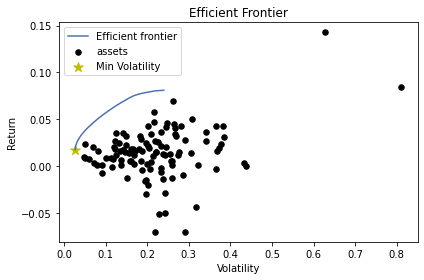

In [19]:
ef1 = EfficientFrontier(mu_Pharm, cov_Pharm, weight_bounds=(0, 0.2))

fig, ax = plt.subplots()
plotting.plot_efficient_frontier(ef1, ax=ax, show_assets=True)

# Find and plot the tangency portfolio
ef2 = EfficientFrontier(mu_Pharm, cov_Pharm, weight_bounds=(0, 0.2))
# min volatility
ef2.min_volatility()
ret_tangent, std_tangent, _ = ef2.portfolio_performance()
ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="y", label="Min Volatility")

# Format
ax.set_title("Efficient Frontier")
ax.legend()
plt.tight_layout()
plt.savefig('images/Efficient_Frontier_Returns.png', dpi=200, bbox_inches='tight')
plt.show()

##### min volatility

In [20]:
ef2.portfolio_performance(verbose=True);

Expected annual return: 1.8%
Annual volatility: 2.7%
Sharpe Ratio: -0.08


In [21]:
companies = []
weights = []
for company, weight in ef2.clean_weights().items():
    if weight != 0:
        companies.append(company)
        weights.append(weight)
        print(company, weight)

XENCOR INC 0.02028
ATHERSYS, INC / NEW 0.04453
ARENA PHARMACEUTICALS INC 0.03982
LILLY ELI & CO 0.02763
VTV THERAPEUTICS INC. 0.03609
ANI PHARMACEUTICALS INC 0.00444
ACTINIUM PHARMACEUTICALS, INC. 0.00031
MERCK & CO., INC. 0.2
RECRO PHARMA, INC. 0.00826
BRISTOL MYERS SQUIBB CO 0.08558
XENON PHARMACEUTICALS INC. 0.01629
ABBVIE INC. 0.01108
KARYOPHARM THERAPEUTICS INC. 0.00495
ZOETIS INC. 0.2
ASSEMBLY BIOSCIENCES, INC. 0.0271
CATALYST PHARMACEUTICALS, INC. 0.02193
JOHNSON & JOHNSON 0.1571
REGENERON PHARMACEUTICALS INC 0.01155
ORAGENICS INC 0.0061
ACHAOGEN INC 0.01319
PROPHASE LABS, INC. 0.05081
BLUEPRINT MEDICINES CORP 0.01296


In [22]:
dic = {'Company_Name':companies,'Weight':weights}
min_vol = pd.DataFrame(dic)
import dataframe_image as dfi
min_vol.dfi.export('min_vol_returns.png')

[0416/201424.351321:INFO:headless_shell.cc(659)] Written to file /var/folders/6t/0lh6qmkn1zg8fhlp984cpxrr0000gn/T/tmpz3pe4nk9/temp.png.


In [23]:
min_vol

,Company_Name,Weight
0,XENCOR INC,0.02028
1,"ATHERSYS, INC / NEW",0.04453
2,ARENA PHARMACEUTICALS INC,0.03982
3,LILLY ELI & CO,0.02763
4,VTV THERAPEUTICS INC.,0.03609
5,ANI PHARMACEUTICALS INC,0.00444
6,"ACTINIUM PHARMACEUTICALS, INC.",0.00031
7,"MERCK & CO., INC.",0.20000
8,"RECRO PHARMA, INC.",0.00826
9,BRISTOL MYERS SQUIBB CO,0.08558
